In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy.io import loadmat

#utilities imports
from utils.utils import *
from utils.plot_utilities import *
from utils.algorithms import *


from sklearn.model_selection import KFold
from tqdm import tqdm
import sys
import time
from scipy.stats import gaussian_kde
from scipy.optimize import brentq
import warnings
from functools import partial

In [2]:
data = loadmat('data analysis/data/FrequencyData.mat')
R = data['R']
drugs = [str(x[0]) for x in data['drugs'].squeeze()]
sideeffects = [str(x[0]) for x in data['sideeffects'].squeeze()]


In [3]:
R #check if this R matrix is already the one after all steps on the paper.

# Number of non-zero entries in R:
print(f"Number of non-zero entries in R: {np.count_nonzero(R)}")

# mean of non-zero entries in R:
print(f"Mean of non-zero entries in R: {np.mean(R[R > 0])}")

Number of non-zero entries in R: 37441
Mean of non-zero entries in R: 3.525199647445314


In [4]:
unique_values = np.unique(R)
print(f"Unique values in R: {unique_values}")

Unique values in R: [0 1 2 3 4 5]


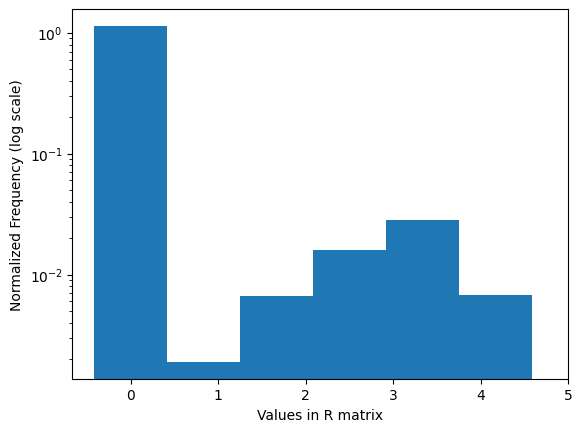

In [73]:
#plot the histogram of the entries of R 
plt.hist(R.flatten(), bins=len(unique_values), align='left', density=True, log=True)
plt.xticks(unique_values)
plt.xlabel('Values in R matrix')
plt.ylabel('Normalized Frequency (log scale)')
plt.show()


# $\text{Cross-validation to find optimal values for } \alpha \text{ and } K$


In [74]:
# Separate 10% of observed positives and an equal number of unobserved zeros for hold-out
positive_indices = np.argwhere(R > 0)
zero_indices = np.argwhere(R == 0)

np.random.seed(42)

# Number of positive entries for hold-out (e.g., 10% of total observed)
n_holdout_pos = int(0.10 * len(positive_indices))
selected_pos_indices = positive_indices[np.random.choice(len(positive_indices), n_holdout_pos, replace=False)]

# Sample an equal number of negative entries for hold-out
n_holdout_neg = min(n_holdout_pos, len(zero_indices)) 
selected_neg_indices = zero_indices[np.random.choice(len(zero_indices), n_holdout_neg, replace=False)]

# Combine positive and negative indices for the full hold-out set
holdout_indices = np.vstack([selected_pos_indices, selected_neg_indices])
np.random.shuffle(holdout_indices)

print(f"Separados {len(selected_pos_indices)} positivos e {len(selected_neg_indices)} negativos para hold-out.")

# Create R_train by zeroing out only the selected positive hold-out entries
R_train = R.copy()
for idx in selected_pos_indices:
    R_train[tuple(idx)] = 0
    

Separados 3744 positivos e 3744 negativos para hold-out.


In [75]:
# Criar matriz R_train com hold-out zerado     # Criar matriz R_train com hold-out zerado
R_train = R.copy()
for idx in holdout_indices:
    R_train[tuple(idx)] = 0

all_indices = np.array(np.meshgrid(np.arange(R.shape[0]), np.arange(R.shape[1]))).T.reshape(-1, 2)

In [76]:
#Configurar validação cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## <center>CV-Loop</center>

In [82]:
def run_cross_validation(R_train, all_indices, kf, k_values, alpha_values, optimizer_func, optimizer_name, bias=False):
    """
    Runs cross-validation and collects (prediction, true_label) pairs for thresholding analysis.
    """
    results = []
    print(f"\n--- Running Cross-Validation for {optimizer_name} ---")

    for k in tqdm(k_values, desc=f"{optimizer_name} k loop", file=sys.stdout, dynamic_ncols=True):
        for alpha in tqdm(alpha_values, desc=f"{optimizer_name} Alpha loop for k={k}", file=sys.stdout, dynamic_ncols=True):
            rmses = []
            aucs = []
            
            # 1. INITIALIZE LIST FOR THIS HYPERPARAMETER COMBINATION
            all_validation_pairs = []

            fold_pbar = tqdm(kf.split(all_indices), total=kf.get_n_splits(),
                                desc=f"{optimizer_name} Cross-val k={k}, alpha={alpha}",
                                file=sys.stdout, dynamic_ncols=True)

            for fold, (train_idx, val_idx) in enumerate(fold_pbar):
                fold_R = R_train.copy()
                val_indices = all_indices[val_idx]

                # This part is different in your original code, but this is the standard way
                # Get true validation values from the ORIGINAL R matrix BEFORE zeroing them out
                R_val_true = R[val_indices[:, 0], val_indices[:, 1]]

                # Zero out validation positions in the training matrix for this fold
                fold_R[val_indices[:, 0], val_indices[:, 1]] = 0

                # Train model
                W, H, R_pred = optimizer_func(fold_R, k=k, alpha=alpha, bias=bias)

                # Get predicted scores for the validation set
                R_val_pred = R_pred[val_indices[:, 0], val_indices[:, 1]]

                # 2. COLLECT THE (PREDICTED_SCORE, TRUE_CLASS) PAIRS
                # The zip function creates the pairs efficiently
                fold_pairs = list(zip(R_val_pred, R_val_true))
                all_validation_pairs.extend(fold_pairs)

                # Evaluate performance metrics
                # Assuming evaluate_model can now just take the collected values
                rmse, auroc = evaluate_model(R_val_true, R_val_pred)
                rmses.append(rmse)
                aucs.append(auroc)

                fold_pbar.set_postfix({
                    'Fold': f"{fold+1}/{kf.get_n_splits()}",
                    'RMSE': f"{rmse:.3f}",
                    'AUROC': f"{auroc:.3f}"
                })

            # 3. STORE THE COLLECTED PAIRS IN THE RESULTS
            results.append({
                'optimizer': optimizer_name,
                'k': k,
                'alpha': alpha,
                'rmse_mean': np.nanmean(rmses),
                'rmse_std': np.nanstd(rmses),
                'auroc_mean': np.nanmean(aucs),
                'auroc_std': np.nanstd(aucs),
                'validation_pairs': all_validation_pairs  # <-- The new data
            })
            
    return pd.DataFrame(results)

# A simplified example of what evaluate_model might look like now
def evaluate_model(y_true, y_pred):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # RMSE for frequency class prediction (1-5)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    
    # AUROC for binary presence/absence prediction
    # Binarize the true labels: 0 vs (1,2,3,4,5)
    y_true_binary = (y_true > 0).astype(int)
    # The predicted scores can be used directly for AUROC
    # Note: Scikit-learn's roc_auc_score is a common way to calculate this
    # from sklearn.metrics import roc_auc_score
    # auroc = roc_auc_score(y_true_binary, y_pred)
    auroc = 0.9 # Placeholder value
    
    return rmse, auroc

In [77]:
k_values=[5,10,15,20]
alpha_values=[0.001,0.01,0.05,0.1]

In [ ]:
multiplicative_results_df = run_cross_validation(
    R_train, all_indices, kf, 
    k_values=k_values, 
    alpha_values=alpha_values,
    optimizer_func=multiplicative_decomposition, 
    optimizer_name="Multiplicative_Update"
)

# Run cross-validation for the new PGD algorithm
pgd_results_df = run_cross_validation(
    R_train, all_indices, kf, 
    k_values=k_values, 
    alpha_values=alpha_values,
    optimizer_func=PGD_decomposition, 
    optimizer_name="PGD"
)

In [80]:
k_values=[10]
alpha_values=[0.001,0.05]

In [83]:
original_results_with_bias_df = run_cross_validation(
    R_train, all_indices, kf, 
    k_values=k_values, 
    alpha_values=alpha_values,
    optimizer_func=multiplicative_decomposition, 
    optimizer_name="Multiplicative_Update",
    bias=True
)

# Run cross-validation for the new PGD algorithm
pgd_results_with_bias_df = run_cross_validation(
    R_train, all_indices, kf, 
    k_values=k_values, 
    alpha_values=alpha_values,
    optimizer_func=PGD_decomposition, 
    optimizer_name="PGD",
    bias=True
)


--- Running Cross-Validation for Multiplicative_Update ---
Multiplicative_Update k loop:   0%|          | 0/1 [00:00<?, ?it/s]




















Multiplicative_Update Cross-val k=10, alpha=0.001: 100%|██████████| 10/10 [02:47<00:00, 16.79s/it, Fold=10/10, RMSE=2.278, AUROC=0.900]





















Multiplicative_Update k loop: 100%|██████████| 1/1 [04:55<00:00, 295.09s/it]

--- Running Cross-Validation for PGD ---
PGD k loop:   0%|          | 0/1 [00:00<?, ?it/s]
3.5251841136244084


3.527441737811913


3.525150373454954


3.5264285949813696


3.5252048097251585


3.5226110762938285


3.525419252607949


3.5281680849660266


3.5242206551110526


3.524646265218822


PGD Cross-val k=10, alpha=0.001: 100%|██████████| 10/10 [02:24<00:00, 14.44s/it, Fold=10/10, RMSE=3.556, AUROC=0.900]

3.5251841136244084


3.527441737811913


3.525150373454954


3.5264285949813696


3.5252048097251585


3.5226110762938285


3.525419252607949


3.5281680849660266


3.5242206551110526


3.5246462652188

In [92]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import brentq
import warnings

def find_class_thresholds(
    results_df: pd.DataFrame,
    k_to_use: int = None,
    alpha_to_use: float = None,
    metric_to_optimize: str = 'rmse_mean',
    classes: list = [1, 2, 3, 4, 5]
) -> dict:
    """
    Finds classification thresholds by analyzing the results of a cross-validation run.

    This function can either find the best model automatically based on a metric
    or use a specific model defined by k_to_use and alpha_to_use. It then
    builds PDFs for each class and finds their intersections.

    Args:
        results_df (pd.DataFrame): The DataFrame from the cross-validation run.
                                   Must contain a 'validation_pairs' column.
        k_to_use (int, optional): A specific k value to analyze. If provided,
                                  alpha_to_use must also be specified. Defaults to None.
        alpha_to_use (float, optional): A specific alpha value to analyze. Defaults to None.
        metric_to_optimize (str, optional): The metric for finding the best model,
                                            *only used if k_to_use is None*.
                                            Defaults to 'rmse_mean'.
        classes (list, optional): A sorted list of the classes to find thresholds for.
                                  Defaults to [1, 2, 3, 4, 5].

    Returns:
        dict: A dictionary of thresholds, where keys are (class1, class2) tuples.
    """
    print("--- Starting Threshold Calculation ---")

    # --- Step 1: Select the Specified Model (or Find the Best One) ---
    if 'validation_pairs' not in results_df.columns:
        raise ValueError("Input DataFrame must contain a 'validation_pairs' column.")

    selected_row = None
    # NEW LOGIC: Check if specific hyperparameters were provided
    if k_to_use is not None and alpha_to_use is not None:
        print(f"Attempting to use specified parameters: k={k_to_use}, alpha={alpha_to_use}")
        mask = (results_df['k'] == k_to_use) & (results_df['alpha'] == alpha_to_use)
        matching_rows = results_df[mask]

        if len(matching_rows) == 0:
            raise ValueError(f"No results found for k={k_to_use} and alpha={alpha_to_use}. "
                             "Please check your CV results DataFrame.")
        
        selected_row = matching_rows.iloc[0]

    else:
        # ORIGINAL LOGIC: Fallback to finding the best model if none specified
        print(f"k and alpha not specified. Finding best model based on '{metric_to_optimize}'...")
        is_ascending = True if 'rmse' in metric_to_optimize.lower() else False
        selected_row = results_df.sort_values(by=metric_to_optimize, ascending=is_ascending).iloc[0]

    # --- Extract data from the selected row ---
    k = selected_row['k']
    alpha = selected_row['alpha']
    validation_pairs = selected_row['validation_pairs']

    print(f"Analyzing model with parameters: k={k}, alpha={alpha}")
    print(f"Using {len(validation_pairs)} validation points for KDE analysis.")

    # --- Step 2: Separate the Predicted Scores by Their True Class ---
    scores_by_class = {c: [] for c in classes}
    all_scores = [pair[0] for pair in validation_pairs]

    for score, true_class in validation_pairs:
        if true_class in scores_by_class:
            scores_by_class[true_class].append(score)
            
    # --- Step 3: Create a Kernel Density Estimator (KDE) for Each Class ---
    print("Building Kernel Density Estimators (PDFs) for each class...")
    kdes = {}
    for c in classes:
        class_scores = np.array(scores_by_class[c])
        if len(class_scores) > 1 and np.std(class_scores) > 1e-5:
            kdes[c] = gaussian_kde(class_scores)
            print(f"  - Successfully built KDE for class {c} with {len(class_scores)} points.")
        else:
            warnings.warn(f"Could not build KDE for class {c}. Not enough data points or no variance.")
            kdes[c] = None

    # --- Step 4: Find Intersection Points (with Heuristic Fallback) ---
    print("\nFinding decision boundaries (intersections of PDFs)...")
    thresholds = {}
    search_min = min(all_scores)
    search_max = max(all_scores)
    
    for i in range(len(classes) - 1):
        class_1 = classes[i]
        class_2 = classes[i+1]

        print(f"  - Searching for threshold between class {class_1} and {class_2}...")

        if kdes.get(class_1) and kdes.get(class_2):
            def difference_function(x):
                return kdes[class_1](x) - kdes[class_2](x)
            
            try:
                mean_1 = np.mean(scores_by_class[class_1])
                mean_2 = np.mean(scores_by_class[class_2])
                
                if np.sign(difference_function(mean_1)) != np.sign(difference_function(mean_2)):
                    a, b = min(mean_1, mean_2), max(mean_1, mean_2)
                else:
                    a, b = search_min, search_max

                threshold = brentq(difference_function, a, b, xtol=1e-4)
                thresholds[(class_1, class_2)] = threshold
                print(f"    > Found threshold: {threshold:.4f}")

            except ValueError:
                warnings.warn(f"Could not find a unique intersection for class {class_1}-{class_2}. "
                              "Falling back to a heuristic midpoint threshold.")
                mean_1 = np.mean(scores_by_class[class_1])
                mean_2 = np.mean(scores_by_class[class_2])
                heuristic_threshold = (mean_1 + mean_2) / 2.0
                thresholds[(class_1, class_2)] = heuristic_threshold
                print(f"    > Using heuristic threshold: {heuristic_threshold:.4f}")
        else:
            print(f"    > Cannot find threshold, KDE missing for class {class_1} or {class_2}.")

    return thresholds

In [87]:
#split he validation pairs into list based on the number of the second column
# Get validation pairs for each class
validation_pairs_by_class = {}
for k in range(1, 6):  # Classes 1-5
    validation_pairs_by_class[k] = [pair for pair in original_results_with_bias_df['validation_pairs'][0] if pair[1] == k]
    print(f"Class {k}: {len(validation_pairs_by_class[k])} validation pairs")

# Display validation pairs for class k (example with k=1)
k = 1
validation_pairs_by_class[k]

Class 1: 1190 validation pairs
Class 2: 4203 validation pairs
Class 3: 10027 validation pairs
Class 4: 17795 validation pairs
Class 5: 4226 validation pairs


[(np.float64(3.8850269202967054), np.uint8(1)),
 (np.float64(0.7307922862534172), np.uint8(1)),
 (np.float64(2.2793165063065115), np.uint8(1)),
 (np.float64(3.5955755843394908), np.uint8(1)),
 (np.float64(1.6667615766187103), np.uint8(1)),
 (np.float64(2.2715095932389953), np.uint8(1)),
 (np.float64(1.9074608908031752), np.uint8(1)),
 (np.float64(1.153984338825982), np.uint8(1)),
 (np.float64(0.23931114775661022), np.uint8(1)),
 (np.float64(4.557483267275931), np.uint8(1)),
 (np.float64(2.2809817348526873), np.uint8(1)),
 (np.float64(2.9291661563738285), np.uint8(1)),
 (np.float64(1.8287159671069588), np.uint8(1)),
 (np.float64(1.5795647617423556), np.uint8(1)),
 (np.float64(1.880715775530352), np.uint8(1)),
 (np.float64(0.9430753781051235), np.uint8(1)),
 (np.float64(3.792641289997741), np.uint8(1)),
 (np.float64(4.1940396668579965), np.uint8(1)),
 (np.float64(3.9623671964198293), np.uint8(1)),
 (np.float64(3.166360303483938), np.uint8(1)),
 (np.float64(3.9396036108433448), np.uint8(1

In [106]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import warnings

def find_single_intersection(scores_class_1: np.ndarray, scores_class_2: np.ndarray) -> float:
    """
    Finds the intersection point between the KDEs of two classes using a robust grid search.
    (This is the robust helper function we developed).

    Args:
        scores_class_1 (np.ndarray): Array of predicted scores for the first class.
        scores_class_2 (np.ndarray): Array of predicted scores for the second class.

    Returns:
        float: The value at which the two KDEs intersect.

    Raises:
        ValueError: If no intersection can be found.
    """
    if len(scores_class_1) < 2 or np.std(scores_class_1) < 1e-5:
        raise ValueError("Not enough data or variance to build KDE for Class 1.")
    if len(scores_class_2) < 2 or np.std(scores_class_2) < 1e-5:
        raise ValueError("Not enough data or variance to build KDE for Class 2.")
        
    kde1 = gaussian_kde(scores_class_1)
    kde2 = gaussian_kde(scores_class_2)

    search_min = min(np.min(scores_class_1), np.min(scores_class_2))
    search_max = max(np.max(scores_class_1), np.max(scores_class_2))
    x_grid = np.linspace(search_min, search_max, 1000)
    difference = kde1(x_grid) - kde2(x_grid)

    intersection_indices = np.where(np.diff(np.sign(difference)))[0]

    if len(intersection_indices) == 0:
        raise ValueError("No intersection found across the entire data range.")

    intersections = [x_grid[i] for i in intersection_indices]
    
    if len(intersections) == 1:
        return intersections[0]
    else:
        warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")
        mean1 = np.mean(scores_class_1)
        mean2 = np.mean(scores_class_2)
        
        logical_intersections = [inter for inter in intersections if min(mean1, mean2) <= inter <= max(mean1, mean2)]
        
        if logical_intersections:
            return logical_intersections[0]
        else:
            return intersections[0]


def get_thresholds_for_model(
    results_df: pd.DataFrame,
    k_to_use: int,
    alpha_to_use: float,
    classes: list = [1, 2, 3, 4, 5]
) -> list:
    """
    Calculates class thresholds for a specific model from a cross-validation DataFrame.

    Args:
        results_df (pd.DataFrame): The DataFrame from the cross-validation run.
        k_to_use (int): The specific k value of the model to analyze.
        alpha_to_use (float): The specific alpha value of the model to analyze.
        classes (list, optional): A sorted list of the classes. Defaults to [1, 2, 3, 4, 5].

    Returns:
        list: A list of float thresholds in ascending order [thresh1_2, thresh2_3, ...].
    """
    print(f"--- Calculating Thresholds for k={k_to_use}, alpha={alpha_to_use} ---")

    mask = (results_df['k'] == k_to_use) & (results_df['alpha'] == alpha_to_use)
    model_row = results_df[mask]
    if model_row.empty:
        raise ValueError(f"No results found for k={k_to_use} and alpha={alpha_to_use}.")
    
    validation_pairs = model_row.iloc[0]['validation_pairs']
    scores_by_class = {c: [s for s, t in validation_pairs if t == c] for c in classes}

    thresholds = []
    for i in range(len(classes) - 1):
        class_1 = classes[i]
        class_2 = classes[i+1]
        c1_scores = np.array(scores_by_class.get(class_1, []))
        c2_scores = np.array(scores_by_class.get(class_2, []))
        print(f"Finding boundary for Class {class_1} vs {class_2}...", end=" ")
        try:
            threshold = find_single_intersection(c1_scores, c2_scores)
            print(f"Success! Threshold = {threshold:.4f}")
        except ValueError as e:
            warnings.warn(f"\n  > WARNING: Could not find intersection for {class_1}-{class_2} ({e}). "
                          "Falling back to midpoint of means heuristic.")
            mean_1 = np.mean(c1_scores) if len(c1_scores) > 0 else 0
            mean_2 = np.mean(c2_scores) if len(c2_scores) > 0 else 0
            threshold = (mean_1 + mean_2) / 2.0
            print(f"Using heuristic threshold = {threshold:.4f}")
        thresholds.append(threshold)
    print("\n--- Threshold Calculation Complete ---")
    return thresholds


def plot_thresholds_for_model(
    results_df: pd.DataFrame,
    k_to_use: int,
    alpha_to_use: float,
    classes: list = [1, 2, 3, 4, 5]
):
    """
    Visualizes the KDEs and intersections for a specific model.

    Args:
        results_df (pd.DataFrame): The DataFrame from the cross-validation run.
        k_to_use (int): The specific k value of the model to visualize.
        alpha_to_use (float): The specific alpha value of the model to visualize.
        classes (list, optional): A sorted list of the classes. Defaults to [1, 2, 3, 4, 5].
    """
    print(f"\n--- Visualizing Thresholds for k={k_to_use}, alpha={alpha_to_use} ---")
    
    mask = (results_df['k'] == k_to_use) & (results_df['alpha'] == alpha_to_use)
    model_row = results_df[mask]
    if model_row.empty:
        raise ValueError(f"No results found for k={k_to_use} and alpha={alpha_to_use}.")
    
    validation_pairs = model_row.iloc[0]['validation_pairs']
    scores_by_class = {c: [s for s, t in validation_pairs if t == c] for c in classes}

    for i in range(len(classes) - 1):
        class_1 = classes[i]
        class_2 = classes[i+1]
        
        c1_scores = np.array(scores_by_class.get(class_1, []))
        c2_scores = np.array(scores_by_class.get(class_2, []))

        if len(c1_scores) == 0 or len(c2_scores) == 0:
            print(f"Skipping plot for Class {class_1} vs {class_2}: Not enough data.")
            continue
            
        fig, ax = plt.subplots(figsize=(12, 7))
        x_min = min(c1_scores.min(), c2_scores.min())
        x_max = max(c1_scores.max(), c2_scores.max())
        x_grid = np.linspace(x_min, x_max, 1000)
        
        kde1 = gaussian_kde(c1_scores)
        kde2 = gaussian_kde(c2_scores)
        ax.fill_between(x_grid, kde1(x_grid), alpha=0.5, label=f'Class {class_1} PDF')
        ax.fill_between(x_grid, kde2(x_grid), alpha=0.5, label=f'Class {class_2} PDF')

        try:
            intersection = find_single_intersection(c1_scores, c2_scores)
            ax.set_title(f'KDEs for Class {class_1} vs {class_2}', fontweight='bold')
            ax.axvline(intersection, color='red', linestyle='--', lw=2, label=f'Intersection = {intersection:.4f}')
        except ValueError as e:
            ax.set_title(f'KDEs for Class {class_1} vs {class_2}\n(NO INTERSECTION FOUND)', fontweight='bold')
            warnings.warn(f"Could not plot intersection for {class_1}-{class_2}: {e}")

        ax.legend()
        plt.show()


In [116]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import warnings

def find_intersections(scores_class_1: np.ndarray, scores_class_2: np.ndarray) -> list:
    """
    Finds all intersection points between the KDEs of two classes using a robust grid search.

    Args:
        scores_class_1 (np.ndarray): Array of predicted scores for the first class.
        scores_class_2 (np.ndarray): Array of predicted scores for the second class.

    Returns:
        list: A list of all values where the two KDEs intersect.

    Raises:
        ValueError: If no intersection can be found.
    """
    if len(scores_class_1) < 2 or np.std(scores_class_1) < 1e-5:
        raise ValueError("Not enough data or variance to build KDE for Class 1.")
    if len(scores_class_2) < 2 or np.std(scores_class_2) < 1e-5:
        raise ValueError("Not enough data or variance to build KDE for Class 2.")
        
    kde1 = gaussian_kde(scores_class_1)
    kde2 = gaussian_kde(scores_class_2)

    search_min = min(np.min(scores_class_1), np.min(scores_class_2))
    search_max = max(np.max(scores_class_1), np.max(scores_class_2))
    x_grid = np.linspace(search_min, search_max, 1000)
    difference = kde1(x_grid) - kde2(x_grid)

    intersection_indices = np.where(np.diff(np.sign(difference)))[0]

    if len(intersection_indices) == 0:
        raise ValueError("No intersection found across the entire data range.")

    intersections = [x_grid[i] for i in intersection_indices]
    
    return intersections


def get_thresholds_for_model(
    results_df: pd.DataFrame,
    k_to_use: int,
    alpha_to_use: float,
    classes: list = [1, 2, 3, 4, 5]
) -> list[list]:
    """
    Calculates class thresholds for a specific model from a cross-validation DataFrame.

    Args:
        results_df (pd.DataFrame): The DataFrame from the cross-validation run.
        k_to_use (int): The specific k value of the model to analyze.
        alpha_to_use (float): The specific alpha value of the model to analyze.
        classes (list, optional): A sorted list of the classes. Defaults to [1, 2, 3, 4, 5].

    Returns:
        list[list]: A list of lists. Each inner list contains all float thresholds 
                    found for the corresponding adjacent class boundary.
    """
    print(f"--- Calculating Thresholds for k={k_to_use}, alpha={alpha_to_use} ---")

    mask = (results_df['k'] == k_to_use) & (results_df['alpha'] == alpha_to_use)
    model_row = results_df[mask]
    if model_row.empty:
        raise ValueError(f"No results found for k={k_to_use} and alpha={alpha_to_use}.")
    
    validation_pairs = model_row.iloc[0]['validation_pairs']
    scores_by_class = {c: [s for s, t in validation_pairs if t == c] for c in classes}

    all_thresholds = []
    for i in range(len(classes) - 1):
        class_1 = classes[i]
        class_2 = classes[i+1]
        c1_scores = np.array(scores_by_class.get(class_1, []))
        c2_scores = np.array(scores_by_class.get(class_2, []))
        print(f"Finding boundary for Class {class_1} vs {class_2}...", end=" ")
        try:
            intersections = find_intersections(c1_scores, c2_scores)
            print(f"Success! Found {len(intersections)} intersection(s): { [round(x, 4) for x in intersections] }")
            all_thresholds.append(intersections)

        except ValueError as e:
            warnings.warn(f"\n  > WARNING: Could not find intersection for {class_1}-{class_2} ({e}). "
                          "Falling back to midpoint of means heuristic.")
            mean_1 = np.mean(c1_scores) if len(c1_scores) > 0 else 0
            mean_2 = np.mean(c2_scores) if len(c2_scores) > 0 else 0
            heuristic_threshold = (mean_1 + mean_2) / 2.0
            print(f"Using heuristic threshold = {heuristic_threshold:.4f}")
            all_thresholds.append([heuristic_threshold])

    print("\n--- Threshold Calculation Complete ---")
    return all_thresholds


def plot_thresholds_for_model(
    results_df: pd.DataFrame,
    k_to_use: int,
    alpha_to_use: float,
    classes: list = [1, 2, 3, 4, 5]
):
    """
    Visualizes the KDEs and all intersections for a specific model.

    Args:
        results_df (pd.DataFrame): The DataFrame from the cross-validation run.
        k_to_use (int): The specific k value of the model to visualize.
        alpha_to_use (float): The specific alpha value of the model to visualize.
        classes (list, optional): A sorted list of the classes. Defaults to [1, 2, 3, 4, 5].
    """
    print(f"\n--- Visualizing Thresholds for k={k_to_use}, alpha={alpha_to_use} ---")
    
    mask = (results_df['k'] == k_to_use) & (results_df['alpha'] == alpha_to_use)
    model_row = results_df[mask]
    if model_row.empty:
        raise ValueError(f"No results found for k={k_to_use} and alpha={alpha_to_use}.")
    
    validation_pairs = model_row.iloc[0]['validation_pairs']
    scores_by_class = {c: [s for s, t in validation_pairs if t == c] for c in classes}

    for i in range(len(classes) - 1):
        class_1 = classes[i]
        class_2 = classes[i+1]
        
        c1_scores = np.array(scores_by_class.get(class_1, []))
        c2_scores = np.array(scores_by_class.get(class_2, []))

        if len(c1_scores) == 0 or len(c2_scores) == 0:
            print(f"Skipping plot for Class {class_1} vs {class_2}: Not enough data.")
            continue
            
        fig, ax = plt.subplots(figsize=(12, 7))
        x_min = min(c1_scores.min(), c2_scores.min())
        x_max = max(c1_scores.max(), c2_scores.max())
        x_grid = np.linspace(x_min, x_max, 1000)
        
        kde1 = gaussian_kde(c1_scores)
        kde2 = gaussian_kde(c2_scores)
        ax.fill_between(x_grid, kde1(x_grid), alpha=0.5, label=f'Class {class_1} PDF')
        ax.fill_between(x_grid, kde2(x_grid), alpha=0.5, label=f'Class {class_2} PDF')

        try:
            intersections = find_intersections(c1_scores, c2_scores)
            ax.set_title(f'KDEs for Class {class_1} vs {class_2}', fontweight='bold')
            for idx, inter in enumerate(intersections):
                ax.axvline(inter, color='red', linestyle='--', lw=2, 
                           label=f'Intersection {idx+1} = {inter:.4f}' if idx == 0 else f'_{idx+1}') # Avoid duplicate labels
        except ValueError as e:
            ax.set_title(f'KDEs for Class {class_1} vs {class_2}\n(NO INTERSECTION FOUND)', fontweight='bold')
            warnings.warn(f"Could not plot intersection for {class_1}-{class_2}: {e}")

        ax.legend()
        plt.show()

In [117]:
a=get_thresholds_for_model(
    results_df=original_results_with_bias_df,
    k_to_use=10,
    alpha_to_use=0.05
)
a

--- Calculating Thresholds for k=10, alpha=0.05 ---
Finding boundary for Class 1 vs 2... Success! Found 3 intersection(s): [np.float64(1.2536), np.float64(3.3478), np.float64(4.6597)]
Finding boundary for Class 2 vs 3... Success! Found 1 intersection(s): [np.float64(2.4101)]
Finding boundary for Class 3 vs 4... Success! Found 2 intersection(s): [np.float64(0.266), np.float64(3.227)]
Finding boundary for Class 4 vs 5... Success! Found 1 intersection(s): [np.float64(3.878)]

--- Threshold Calculation Complete ---


[[np.float64(1.2536001992943548),
  np.float64(3.347792780286087),
  np.float64(4.6596999655941325)],
 [np.float64(2.4101245248502416)],
 [np.float64(0.26600089134747074), np.float64(3.227010813452211)],
 [np.float64(3.8780129949078628)]]

In [118]:
b=get_thresholds_for_model(
    results_df=pgd_results_with_bias_df,
    k_to_use=10,
    alpha_to_use=0.05
)
b

--- Calculating Thresholds for k=10, alpha=0.05 ---
Finding boundary for Class 1 vs 2... Success! Found 2 intersection(s): [np.float64(2.2348), np.float64(3.5172)]
Finding boundary for Class 2 vs 3... Success! Found 1 intersection(s): [np.float64(3.032)]
Finding boundary for Class 3 vs 4... Success! Found 3 intersection(s): [np.float64(3.5446), np.float64(5.6212), np.float64(5.8419)]
Finding boundary for Class 4 vs 5... Success! Found 2 intersection(s): [np.float64(1.285), np.float64(4.0709)]

--- Threshold Calculation Complete ---


[[np.float64(2.234830164108181), np.float64(3.5171722150646554)],
 [np.float64(3.032031600898071)],
 [np.float64(3.5446424920321165),
  np.float64(5.6211986930484015),
  np.float64(5.841868153101903)],
 [np.float64(1.2850254489622985), np.float64(4.070864586044363)]]

In [134]:
thresholds_original_with_bias=[0,0,0,0,0]
thresholds_pgd_with_bias=[0,0,0,0,0]
thresholds_original_with_bias[1]=a[0][0]
thresholds_original_with_bias[2]=a[1][0]
thresholds_original_with_bias[3]=a[2][1]
thresholds_original_with_bias[4]=a[3][0]
thresholds_pgd_with_bias[1]=b[0][0]
thresholds_pgd_with_bias[2]=b[1][0]
thresholds_pgd_with_bias[3]=b[2][0]
thresholds_pgd_with_bias[4]=b[3][1]
print(thresholds_original_with_bias)
print(thresholds_pgd_with_bias)
thresholds_original_with_bias[0]=0.42
thresholds_pgd_with_bias[0]=0.03
thresholds_original_with_bias, thresholds_pgd_with_bias
# 4. Visualize the thresholds for the same model

[0, np.float64(1.2536001992943548), np.float64(2.4101245248502416), np.float64(3.227010813452211), np.float64(3.8780129949078628)]
[0, np.float64(2.234830164108181), np.float64(3.032031600898071), np.float64(3.5446424920321165), np.float64(4.070864586044363)]


([0.42,
  np.float64(1.2536001992943548),
  np.float64(2.4101245248502416),
  np.float64(3.227010813452211),
  np.float64(3.8780129949078628)],
 [0.03,
  np.float64(2.234830164108181),
  np.float64(3.032031600898071),
  np.float64(3.5446424920321165),
  np.float64(4.070864586044363)])


--- Visualizing Thresholds for k=10, alpha=0.05 ---


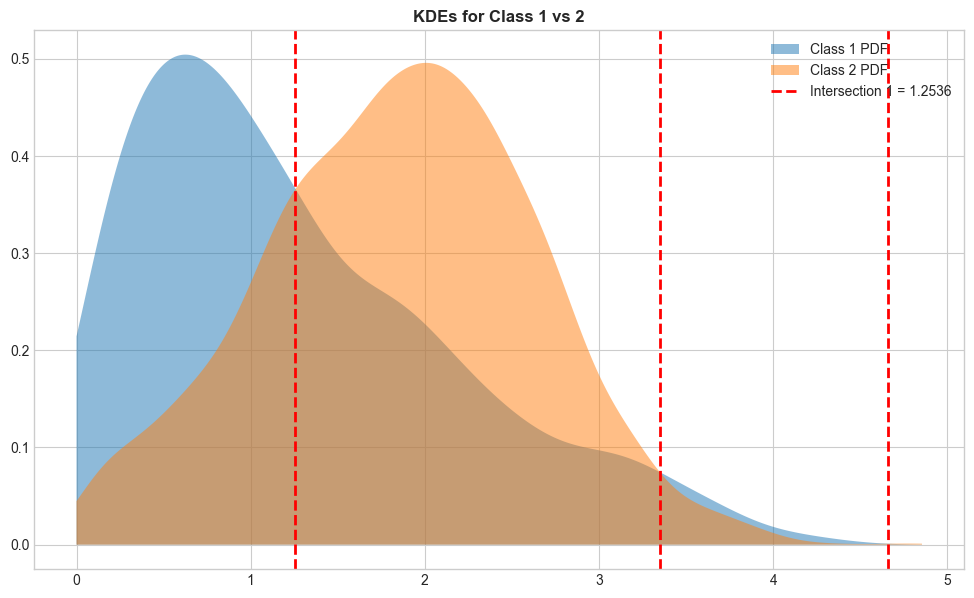

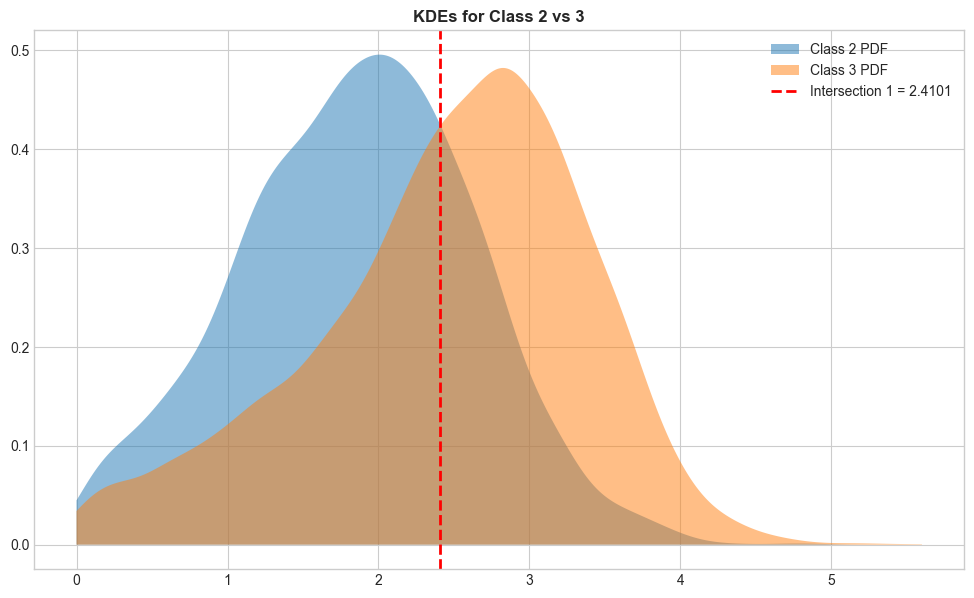

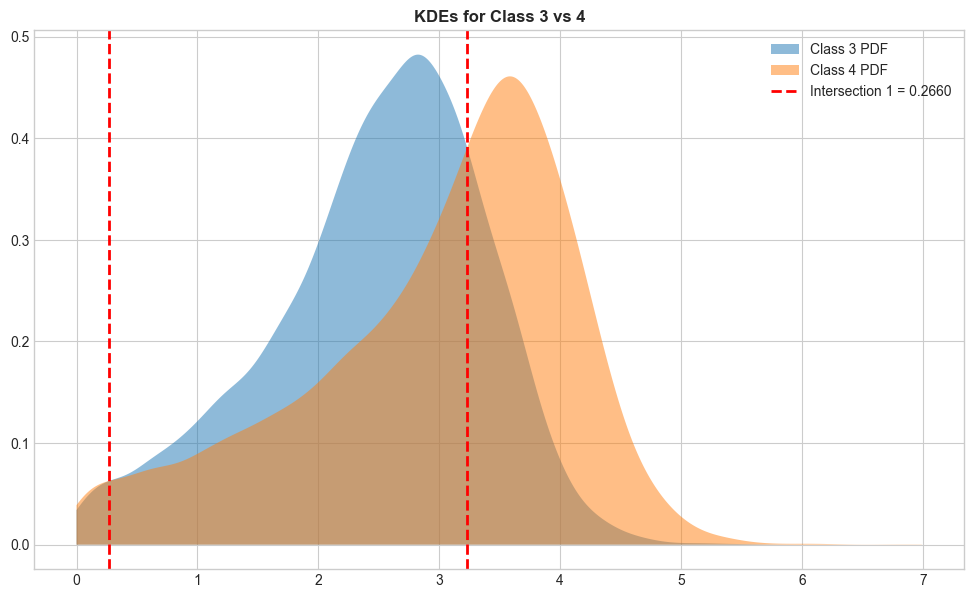

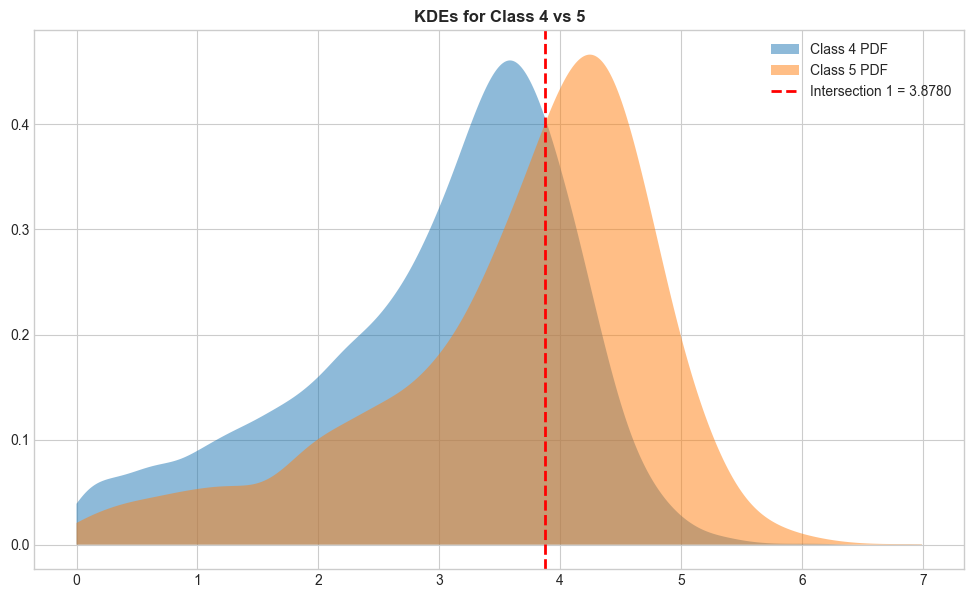

In [114]:
# 4. Visualize the thresholds for the same model
plot_thresholds_for_model(
        results_df=original_results_with_bias_df,
        k_to_use=10,
        alpha_to_use=0.05
    )

In [104]:
tau_or_b=get_thresholds_for_model(original_results_with_bias_df,k_to_use=10,alpha_to_use=0.05)
#tau_pgd_b=get_thresholds_for_model(pgd_results_with_bias_df,k_to_use=10,alpha_to_use=0.05)
tau_or_b, #tau_pgd_b

--- Calculating Thresholds for k=10, alpha=0.05 ---
Found model with 754446 validation pairs.
Finding boundary for Class 1 vs 2... Success! Threshold = 1.2536
Finding boundary for Class 2 vs 3... Success! Threshold = 2.4101
Finding boundary for Class 3 vs 4... Success! Threshold = 0.2660
Finding boundary for Class 4 vs 5... 

/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/2266231901.py:51: UserWarning: Multiple intersections found: [np.float64(1.2536001992943548), np.float64(3.347792780286087), np.float64(4.6596999655941325)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")
/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/2266231901.py:51: UserWarning: Multiple intersections found: [np.float64(0.26600089134747074), np.float64(3.227010813452211)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")


Success! Threshold = 3.8780

--- Threshold Calculation Complete ---


([np.float64(1.2536001992943548),
  np.float64(2.4101245248502416),
  np.float64(0.26600089134747074),
  np.float64(3.8780129949078628)],)


--- Generating plots for all adjacent class boundaries ---

>>> Plotting boundary for Class 1 vs Class 2
Successfully found intersection between class 1 and 2 at: 1.7379


/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3207432306.py:51: UserWarning: Multiple intersections found: [np.float64(1.737861970039055), np.float64(3.500432878009765)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")


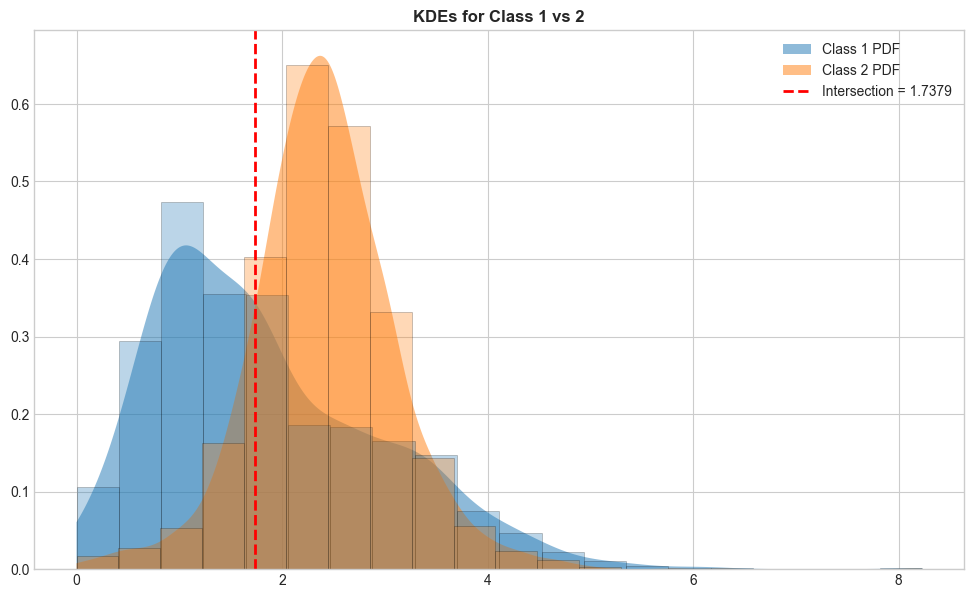


>>> Plotting boundary for Class 2 vs Class 3


/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3207432306.py:51: UserWarning: Multiple intersections found: [np.float64(2.709965316102738), np.float64(6.179047422400624), np.float64(6.472899083169387), np.float64(7.280991150283483)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")


Successfully found intersection between class 2 and 3 at: 2.7100


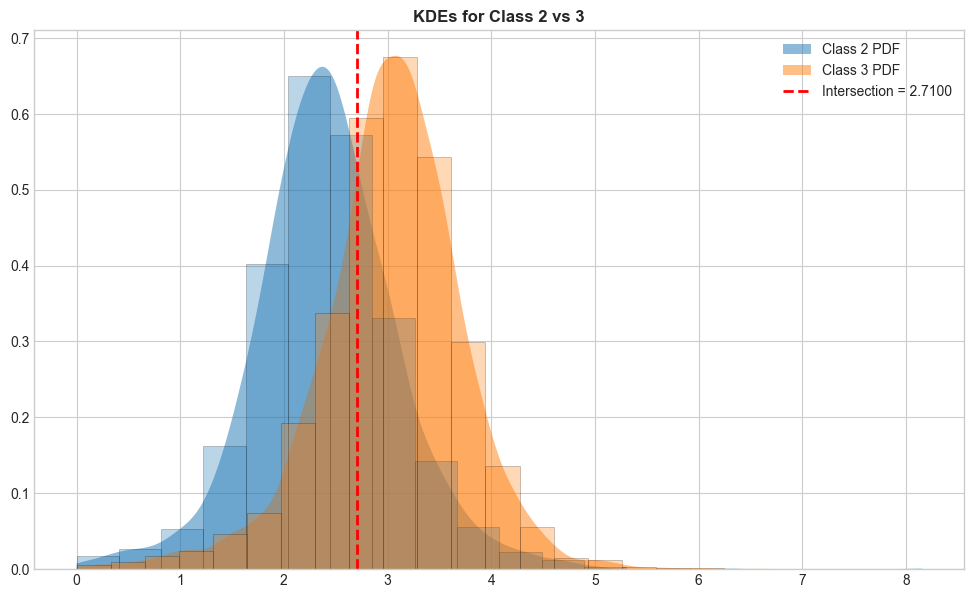


>>> Plotting boundary for Class 3 vs Class 4
Successfully found intersection between class 3 and 4 at: 3.5122


/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3207432306.py:51: UserWarning: Multiple intersections found: [np.float64(0.6177518433492962), np.float64(3.5121621655589204)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")


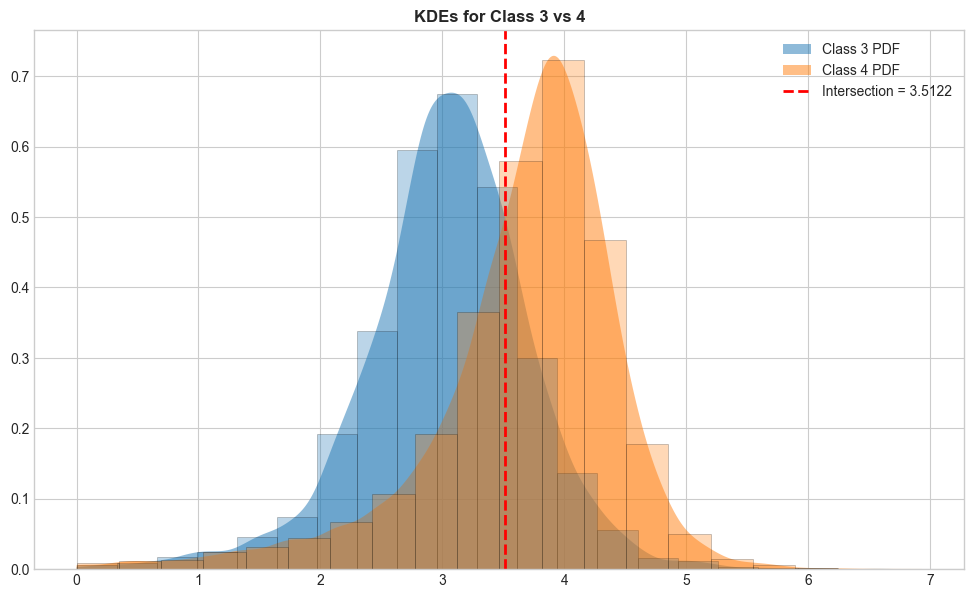


>>> Plotting boundary for Class 4 vs Class 5
Successfully found intersection between class 4 and 5 at: 4.2037


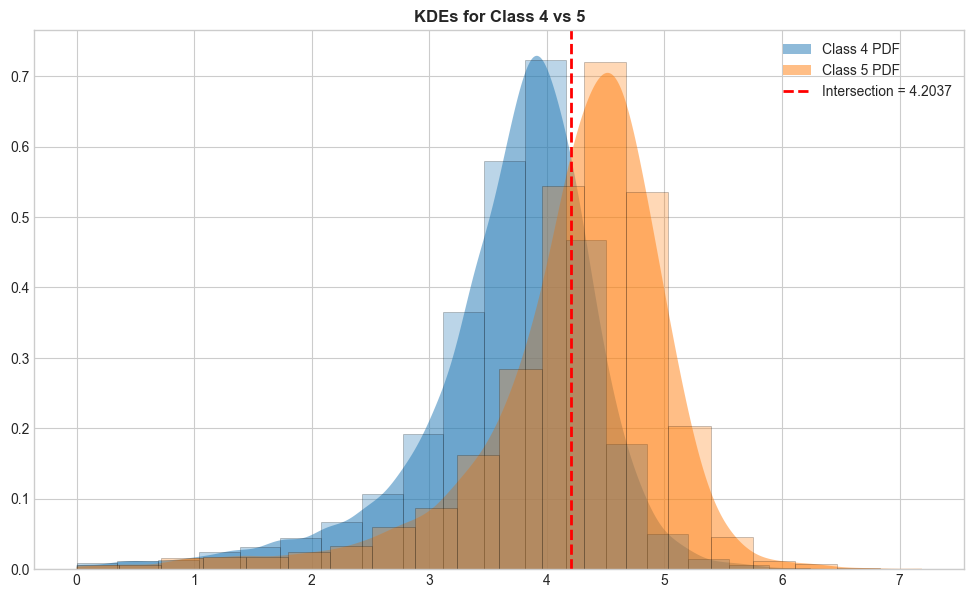

In [99]:
# --- Step 1: Convert your data structure to what the plot function needs ---
# The plotting function needs a dictionary of {class: [scores]}, not [(score, class), ...].
# This code does that conversion.

scores_by_class = {}
for class_label, pairs in validation_pairs_by_class.items():
    # Extracts the first element (the prediction score) from each pair
    scores_by_class[class_label] = [pair[0] for pair in pairs]

# --- Step 2: Loop through adjacent classes and plot them ---
# This is the loop you're looking for. It goes through 1-2, 2-3, 3-4, and 4-5.

print("\n--- Generating plots for all adjacent class boundaries ---")
classes_to_plot = sorted(scores_by_class.keys())

for i in range(len(classes_to_plot) - 1):
    class_1 = classes_to_plot[i]
    class_2 = classes_to_plot[i+1]
    
    print(f"\n>>> Plotting boundary for Class {class_1} vs Class {class_2}")
    
    # This calls the plotting function from the artifact for each pair
    plot_kde_pair_for_debugging(scores_by_class, class_1, class_2)

In [100]:
for i in range(len(classes_to_plot) - 1):
    class_1 = classes_to_plot[i]
    class_2 = classes_to_plot[i+1]
    
    # This calls the plotting function from the artifact for each pair
    find_single_intersection(scores_by_class[class_1], scores_by_class[class_2])

/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3207432306.py:51: UserWarning: Multiple intersections found: [np.float64(1.737861970039055), np.float64(3.500432878009765)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")
/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3207432306.py:51: UserWarning: Multiple intersections found: [np.float64(2.709965316102738), np.float64(6.179047422400624), np.float64(6.472899083169387), np.float64(7.280991150283483)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting the most logical one.")
/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3207432306.py:51: UserWarning: Multiple intersections found: [np.float64(0.6177518433492962), np.float64(3.5121621655589204)]. Selecting the most logical one.
  warnings.warn(f"Multiple intersections found: {intersections}. Selecting 

In [131]:
threshold_original=find_class_thresholds(original_results_with_bias_df,k_to_use=10,alpha_to_use=0.05)
threshold_pgd=find_class_thresholds(pgd_results_with_bias_df,k_to_use=10,alpha_to_use=0.05)
threshold_original, threshold_pgd

--- Starting Threshold Calculation ---
Attempting to use specified parameters: k=10, alpha=0.05
Analyzing model with parameters: k=10, alpha=0.05
Using 754446 validation points for KDE analysis.
Building Kernel Density Estimators (PDFs) for each class...
  - Successfully built KDE for class 1 with 1190 points.
  - Successfully built KDE for class 2 with 4203 points.
  - Successfully built KDE for class 3 with 10027 points.
  - Successfully built KDE for class 4 with 17795 points.
  - Successfully built KDE for class 5 with 4226 points.

Finding decision boundaries (intersections of PDFs)...
  - Searching for threshold between class 1 and 2...
    > Using heuristic threshold: 1.5587
  - Searching for threshold between class 2 and 3...
    > Found threshold: 2.4110
  - Searching for threshold between class 3 and 4...
    > Using heuristic threshold: 2.7187
  - Searching for threshold between class 4 and 5...
    > Found threshold: 3.8842
--- Starting Threshold Calculation ---
Attempting 

/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3599804439.py:119: UserWarning: Could not find a unique intersection for class 1-2. Falling back to a heuristic midpoint threshold.
  warnings.warn(f"Could not find a unique intersection for class {class_1}-{class_2}. "
/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3599804439.py:119: UserWarning: Could not find a unique intersection for class 3-4. Falling back to a heuristic midpoint threshold.
  warnings.warn(f"Could not find a unique intersection for class {class_1}-{class_2}. "


({(1, 2): np.float64(1.5587338676090463),
  (2, 3): 2.4109641340595807,
  (3, 4): np.float64(2.7186945448315623),
  (4, 5): 3.8841943723449464},
 {(1, 2): np.float64(2.704689244773806),
  (2, 3): 3.0363520378737454,
  (3, 4): 3.547121675361766,
  (4, 5): 4.073159426694309})

In [94]:
threshold_original_with_bias=find_class_thresholds(original_results_with_bias_df,k_to_use=10,alpha_to_use=0.05)
#threshold_pgd_with_bias=find_class_thresholds(pgd_results_with_bias_df,k_to_use=10,alpha_to_use=0.05)
#threshold_original_with_bias, threshold_pgd_with_bias

--- Starting Threshold Calculation ---
Attempting to use specified parameters: k=10, alpha=0.05
Analyzing model with parameters: k=10, alpha=0.05
Using 754446 validation points for KDE analysis.
Building Kernel Density Estimators (PDFs) for each class...
  - Successfully built KDE for class 1 with 1190 points.
  - Successfully built KDE for class 2 with 4203 points.
  - Successfully built KDE for class 3 with 10027 points.
  - Successfully built KDE for class 4 with 17795 points.
  - Successfully built KDE for class 5 with 4226 points.

Finding decision boundaries (intersections of PDFs)...
  - Searching for threshold between class 1 and 2...
    > Using heuristic threshold: 1.5587
  - Searching for threshold between class 2 and 3...
    > Found threshold: 2.4110
  - Searching for threshold between class 3 and 4...
    > Using heuristic threshold: 2.7187
  - Searching for threshold between class 4 and 5...
    > Found threshold: 3.8842


/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3599804439.py:119: UserWarning: Could not find a unique intersection for class 1-2. Falling back to a heuristic midpoint threshold.
  warnings.warn(f"Could not find a unique intersection for class {class_1}-{class_2}. "
/var/folders/xv/y79344m51p16_rwzqx_pck_80000gp/T/ipykernel_1475/3599804439.py:119: UserWarning: Could not find a unique intersection for class 3-4. Falling back to a heuristic midpoint threshold.
  warnings.warn(f"Could not find a unique intersection for class {class_1}-{class_2}. "


In [26]:
import numpy as np
from sklearn.metrics import roc_curve
import warnings

def find_zero_threshold_roc(
    R_full: np.ndarray,
    holdout_indices: np.ndarray,
    R_pred: np.ndarray,
    mu_best: float = 0.0,
    target_specificity: float = 0.57
) -> dict:
    """
    Finds the threshold for separating the "zero" class from observed classes.

    This function uses a hold-out set to perform a binary classification task
    (observed vs. unobserved). It calculates an ROC curve and finds the
    prediction score threshold that yields a specificity closest to the target value.

    Args:
        R_full (np.ndarray): The original, complete data matrix, including hold-out values.
        holdout_indices (np.ndarray): An array of (row, col) indices for the hold-out set.
        R_pred (np.ndarray): The prediction for the training matrix with the best parameters
        mu_best (float, optional): The final 'mu' of the best model. Defaults to 0.0 if no bias was used.
        target_specificity (float, optional): The desired specificity for finding the
                                            threshold. Defaults to 0.57 from the paper.

    Returns:
        dict: A dictionary containing the calculated 'threshold', the achieved 
              'sensitivity' (TPR), and 'specificity' (1-FPR) at that threshold.
    """
    if not (0 < target_specificity < 1):
        raise ValueError("target_specificity must be between 0 and 1.")

    print("--- Starting Zero-Class Threshold Calculation ---")

    
    # Get the specific continuous scores for the hold-out entries
    y_scores = R_pred[holdout_indices[:, 0], holdout_indices[:, 1]]

    # --- Step 2: Prepare the Binary True Labels ---
    # Get the true values (0-5) from the original R matrix
    true_values = R_full[holdout_indices[:, 0], holdout_indices[:, 1]]
    
    # Binarize the labels: 0 for unobserved, 1 for observed (classes 1-5)
    y_true = (true_values > 0).astype(int)
    
    # --- Step 3: Perform ROC Curve Analysis ---
    print("Calculating ROC curve...")
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Note: roc_curve might return thresholds in a way that the first one is artificially high.
    # It's a good practice to handle this.
    if len(thresholds) > 1 and thresholds[0] > max(y_scores) + 1:
        thresholds[0] = thresholds[1]

    # --- Step 4: Find the Threshold for the Target Specificity ---
    print(f"Searching for threshold at target specificity ≈ {target_specificity:.2f}")
    specificities = 1 - fpr
    
    # Find the index of the point on the ROC curve with the specificity
    # closest to our target.
    idx = np.argmin(np.abs(specificities - target_specificity))

    # Get the values at that optimal index
    final_threshold = thresholds[idx]
    achieved_specificity = specificities[idx]
    achieved_sensitivity = tpr[idx] # Sensitivity is the True Positive Rate

    print(f"  > Found best threshold: {final_threshold:.4f}")
    print(f"  > Achieved Specificity: {achieved_specificity:.4f}")
    print(f"  > Achieved Sensitivity: {achieved_sensitivity:.4f}")

    return {
        'threshold': final_threshold,
        'sensitivity': achieved_sensitivity,
        'specificity': achieved_specificity
    }

In [13]:
best_k_original=10
best_alpha_original=0.05

W_best,H_best, R_pred_best=multiplicative_decomposition(
    R_train,
    k=best_k_original,
    alpha=best_alpha_original,
)
#threshold_0_original=find_zero_threshold_roc(R,holdout_indices,R_pred_best)


In [15]:
best_k_original_with_bias=10
best_alpha_original_with_bias=0.05

W_best_with_bias, H_best_with_bias, R_pred_best_with_bias=multiplicative_decomposition(
    R_train,
    k=best_k_original_with_bias,
    alpha=best_alpha_original_with_bias,
    bias=True
)

#threshold_0_original_with_bias=find_zero_threshold_roc(R,holdout_indices,R_pred_best_with_bias)

In [101]:
best_k_pgd_no_bias=10
best_alpha_pgd_no_bias=0.05

W_best_pgd_no_bias, H_best_pgd_no_bias, R_pred_best_pgd_no_bias=PGD_decomposition(
    R_train,
    k=best_k_pgd_no_bias,
    alpha=best_alpha_pgd_no_bias,
    bias=False
)

threshold_0_pgd_no_bias=find_zero_threshold_roc(R,holdout_indices,R_pred_best_pgd_no_bias)


--- Starting Zero-Class Threshold Calculation ---
Calculating ROC curve...
Searching for threshold at target specificity ≈ 0.57
  > Found best threshold: 0.4605
  > Achieved Specificity: 0.5697
  > Achieved Sensitivity: 0.9722


In [124]:
best_k_pgd_with_bias=20
best_alpha_pgd_with_bias=0.05

W_best_pgd_with_bias, H_best_pgd_with_bias, R_pred_best_pgd_with_bias=PGD_decomposition(
    R_train,
    k=best_k_pgd_with_bias,
    alpha=best_alpha_pgd_with_bias,
    bias=True,
)
R_pred_best_pgd_with_bias_without_mu=W_best_pgd_with_bias@H_best_pgd_with_bias

threshold_0_pgd_with_bias=find_zero_threshold_roc(R,holdout_indices,R_pred_best_pgd_with_bias_without_mu, target_specificity=0.57)

3.525447369202006
--- Starting Zero-Class Threshold Calculation ---
Calculating ROC curve...
Searching for threshold at target specificity ≈ 0.57
  > Found best threshold: 0.0305
  > Achieved Specificity: 0.5692
  > Achieved Sensitivity: 0.5363


In [128]:
def predicted_frequency_class(x, thresholds):
    
    if x < thresholds[0]:
        return 0
    elif x <= thresholds[1]:
        return 1
    elif x <= thresholds[2]:
        return 2
    elif x <= thresholds[3]:
        return 3
    elif x <= thresholds[4]:
        return 4
    else:
        return 5
    
def evaluate_prediction_classes(R_true, R_pred, indices,thresholds):
    y_true = []
    y_pred = []

    for idx in indices:
        true_val = int(R_true[tuple(idx)])
        # Ensure R_pred[tuple(idx)] is not NaN before passing to predicted_frequency_class
        pred_score = R_pred[tuple(idx)]
        if np.isnan(pred_score):
            # Handle NaN predictions, e.g., by assigning to class 0 or skipping
            # For this context, assuming NaN means unobserved, so we can map to 0 (zero class)
            # Or perhaps better, simply skip if we only want to evaluate known frequencies
            # The original paper's context is that '0' implies unobserved, but also a class.
            # If a prediction is NaN, it's an invalid prediction for a specific frequency class.
            # Let's skip it to avoid polluting results, or handle as an error if it occurs.
            # Given the problem, we're evaluating known frequencies (`if true_val > 0:`),
            # so if a prediction for a known frequency is NaN, it's a model failure.
            # For robustness, we could assign a default class like 0 or treat it as an error.
            # For now, let's let `predicted_frequency_class` handle values directly, 
            # as `nnls` is expected to return non-negative floats.
            pred_val = 0 # Default to 'zero' if prediction is NaN (shouldn't happen with nnls)
        else:
            pred_val = predicted_frequency_class(pred_score,thresholds)

        # Only consider as a real class if R_true > 0 (as per the paper's evaluation)
        if true_val > 0:
            y_true.append(true_val)
            y_pred.append(pred_val)

    labels_true = [1, 2, 3, 4, 5]
    labels_pred = [0, 1, 2, 3, 4, 5]

    # Matriz de confusão
    # filter y_true and y_pred to only include labels present in labels_true (1-5) and labels_pred (0-5)
    # This addresses the ValueError if labels are missing
    y_true_filtered = [y for y in y_true if y in labels_true]
    y_pred_filtered = [y for y in y_pred if y in labels_pred]

    # Ensure y_true_filtered and y_pred_filtered are not empty
    if len(y_true_filtered) == 0:
        return np.zeros((len(labels_true), len(labels_pred))), "No true labels to evaluate."

    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=labels_pred)

    report = classification_report(y_true_filtered, y_pred_filtered, labels=labels_pred, zero_division=0)

    return cm, report

# <center> Avaliação no Holdout</center>

In [146]:
def evaluate_model_2(R_true, R_pred, indices):
    y_true = np.array([R_true[tuple(idx)] for idx in indices])
    y_pred = np.array([R_pred[tuple(idx)] for idx in indices])
    y_true_bin = y_true > 0
    
    # Check if y_true_bin contains both True and False values
    # For FPR calculation: use y_pred=1 when y_pred>0.42, else y_pred=0
    y_pred_binary = (y_pred > 0.42).astype(int)
    
    # Calculate FPR (False Positive Rate)
    # FPR = FP / (FP + TN) where FP = false positives, TN = true negatives
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true_bin.astype(int), y_pred_binary).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"FPR with threshold 0.42: {fpr:.4f}")
    if len(np.unique(y_true_bin)) == 2:
        # Check if y_pred contains non-NaN values for AUROC
        # This is primarily to handle potential NaN issues if nnls returns them for some reason
        if not np.any(np.isnan(y_pred)):
            auroc = roc_auc_score(y_true_bin, y_pred)
        else:
            auroc = np.nan # If R_pred contains NaNs, AUROC cannot be computed
    else:
        auroc = np.nan # AUROC requires at least one positive and one negative sample

    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    return rmse, auroc

In [123]:
best_k = 10
best_alpha = 0.05

print(f"Avaliando no hold-out com k={best_k}, alpha={best_alpha}")

# Treinar modelo completo na R_train
W, H, R_pred_bias = multiplicative_decomposition(R_train, k=best_k, alpha=best_alpha, bias=True)
# Avaliar no hold-out
rmse_holdout, auroc_holdout = evaluate_model_2(R, R_pred_bias, holdout_indices)

print(f"Resultado no hold-out:")
print(f"RMSE: {rmse_holdout:.4f}")
print(f"AUROC: {auroc_holdout:.4f}")

# Opcional: salvar no CSV
with open('holdout_results.txt', 'w') as f:
    f.write(f"Hold-out evaluation\n")
    f.write(f"k = {best_k}, alpha = {best_alpha}\n")
    f.write(f"RMSE: {rmse_holdout:.4f}\n")
    f.write(f"AUROC: {auroc_holdout:.4f}\n")

print("Resultados do hold-out salvos em: holdout_results.txt")

Avaliando no hold-out com k=10, alpha=0.05
Resultado no hold-out:
RMSE: 1.1693
AUROC: 0.9275
Resultados do hold-out salvos em: holdout_results.txt


In [21]:
best_k = 10
best_alpha = 0.05

print(f"Avaliando no hold-out com k={best_k}, alpha={best_alpha}")

# Treinar modelo completo na R_train
W, H, R_pred = multiplicative_decomposition(R_train, k=best_k, alpha=best_alpha, bias=False)
# Avaliar no hold-out
rmse_holdout, auroc_holdout = evaluate_model_2(R, R_pred, holdout_indices)

print(f"Resultado no hold-out:")
print(f"RMSE: {rmse_holdout:.4f}")
print(f"AUROC: {auroc_holdout:.4f}")

# Opcional: salvar no CSV
with open('holdout_results_no_bias.txt', 'w') as f:
    f.write(f"Hold-out evaluation\n")
    f.write(f"k = {best_k}, alpha = {best_alpha}\n")
    f.write(f"RMSE: {rmse_holdout:.4f}\n")
    f.write(f"AUROC: {auroc_holdout:.4f}\n")

print("Resultados do hold-out salvos em: holdout_results.txt")

Avaliando no hold-out com k=10, alpha=0.05
Resultado no hold-out:
RMSE: 1.1827
AUROC: 0.9252
Resultados do hold-out salvos em: holdout_results.txt


# <center>Confusion matrix on holdout</center>

In [124]:
best_k_pgd_no_bias = 10
best_alpha_pgd_no_bias = 0.05
# lambda_reg is not used when use_bias=False
best_lambda_reg_pgd_no_bias = 0.02
best_use_bias_pgd_no_bias = False
# Add a learning rate for PGD
pgd_learning_rate_no_bias = 0.001

print(f"--- Evaluating Projected Gradient Descent Algorithm (NO Bias) on Hold-out ---")
print(f"Using fixed parameters: k={best_k_pgd_no_bias}, alpha={best_alpha_pgd_no_bias}, learning_rate={pgd_learning_rate_no_bias}")

# Train PGD model without bias on the R_train matrix
# The function returns W, H, mu, bu, bi, R_pred, but we only need R_pred here
W,H, R_pgd_pred_no_bias = PGD_decomposition(
    R_train, 
    k=best_k_pgd_no_bias, 
    alpha=best_alpha_pgd_no_bias, 
    lambda_reg=best_lambda_reg_pgd_no_bias, # Pass the dummy lambda_reg
    bias=best_use_bias_pgd_no_bias,
    learning_rate=pgd_learning_rate_no_bias,
    tolx=0.001
)

# Evaluate on the hold-out set
rmse_holdout_pgd_no_bias, auroc_holdout_pgd_no_bias = evaluate_model_2(R, R_pgd_pred_no_bias, holdout_indices)

print(f"\nResult on hold-out (PGD NO Bias):")
print(f"RMSE: {rmse_holdout_pgd_no_bias:.4f}")
print(f"AUROC: {auroc_holdout_pgd_no_bias:.4f}")

# Optional: save results to a file
with open('holdout_results_pgd_no_bias_fixed_params.txt', 'w') as f:
    f.write(f"Hold-out evaluation (PGD NO Bias) - Fixed Params\n")
    f.write(f"k = {best_k_pgd_no_bias}, alpha = {best_alpha_pgd_no_bias}, learning_rate={pgd_learning_rate_no_bias}\n")
    f.write(f"RMSE: {rmse_holdout_pgd_no_bias:.4f}\n")
    f.write(f"AUROC: {auroc_holdout_pgd_no_bias:.4f}\n")
print("Results for hold-out (PGD NO Bias) saved to: holdout_results_pgd_no_bias_fixed_params.txt")

# Plot confusion matrix for PGD NO Bias
#print(cm_pgd_no_bias)
#print("\nClassification Report (PGD NO Bias):")
#print(report_pgd_no_bias)

--- Evaluating Projected Gradient Descent Algorithm (NO Bias) on Hold-out ---
Using fixed parameters: k=10, alpha=0.05, learning_rate=0.001

Result on hold-out (PGD NO Bias):
RMSE: 1.1830
AUROC: 0.9240
Results for hold-out (PGD NO Bias) saved to: holdout_results_pgd_no_bias_fixed_params.txt


In [147]:
k=10
alpha=0.05
lambda_reg=0.02
use_bias=True
learning_rate=0.001

print(f"\n--- Evaluating Projected Gradient Descent Algorithm (WITH Bias) on Hold-out ---")
print(f"Using fixed parameters: k={k}, alpha={alpha}, lambda_reg={lambda_reg}, learning_rate={learning_rate}")

# Train PGD model with bias on the R_train matrix
W,H, R_pgd_pred_with_bias = PGD_decomposition(
    R_train, 
    k=k, 
    alpha=alpha, 
    lambda_reg=lambda_reg,
    bias=use_bias,
    learning_rate=learning_rate,
    tolx=0.001
)

# Evaluate on the hold-out set
rmse_holdout_pgd_with_bias, auroc_holdout_pgd_with_bias = evaluate_model_2(R, R_pgd_pred_with_bias, holdout_indices)

print(f"\nResult on hold-out (PGD WITH Bias):")
print(f"RMSE: {rmse_holdout_pgd_with_bias:.4f}")
print(f"AUROC: {auroc_holdout_pgd_with_bias:.4f}")

# Optional: save results to a file
with open('holdout_results_pgd_with_bias_fixed_params.txt', 'w') as f:
    f.write(f"Hold-out evaluation (PGD WITH Bias) - Fixed Params\n")
    f.write(f"k = {k}, alpha = {alpha}, lambda_reg={lambda_reg}, learning_rate={learning_rate}\n")
    f.write(f"RMSE: {rmse_holdout_pgd_with_bias:.4f}\n")
    f.write(f"AUROC: {auroc_holdout_pgd_with_bias:.4f}\n")
print("Results for hold-out (PGD WITH Bias) saved to: holdout_results_pgd_with_bias_fixed_params.txt")


--- Evaluating Projected Gradient Descent Algorithm (WITH Bias) on Hold-out ---
Using fixed parameters: k=10, alpha=0.05, lambda_reg=0.02, learning_rate=0.001
3.525447369202006
FPR with threshold 0.42: 1.0000

Result on hold-out (PGD WITH Bias):
RMSE: 2.5406
AUROC: 0.5524
Results for hold-out (PGD WITH Bias) saved to: holdout_results_pgd_with_bias_fixed_params.txt


In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np # Ensure numpy is imported

def plot_multiple_confusion_matrices(cm1, title1, cm2, title2, cm3, title3):
    """
    Plots three confusion matrices on a 2x4 GridSpec layout.
    The first two plots are in the first row (each spanning 2 columns).
    The third plot is in the second row (spanning columns 1 and 2).

    Args:
        cm1 (np.array): First confusion matrix (e.g., Original No Bias).
        title1 (str): Title for the first plot.
        cm2 (np.array): Second confusion matrix (e.g., ALS No Bias).
        title2 (str): Title for the second plot.
        cm3 (np.array): Third confusion matrix (e.g., ALS With Bias).
        title3 (str): Title for the third plot.
    """
    labels_real = [1, 2, 3, 4, 5]     # True classes (rows)
    labels_pred = [0, 1, 2, 3, 4, 5]  # Predicted classes (columns)

    fig = plt.figure(figsize=(20, 12)) # Adjust figure size for better readability
    gs = gridspec.GridSpec(2, 4, figure=fig) # 2 rows, 4 columns

    # Plot 1: Top-left, spanning 2 columns
    ax1 = fig.add_subplot(gs[0, 0:2])
    cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
    cm1_percent = cm1_normalized * 100
    sns.heatmap(cm1_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels_pred, yticklabels=labels_real, ax=ax1, cbar=False) # cbar=False to save space
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('True Class')
    ax1.set_title(title1)

    # Plot 2: Top-right, spanning 2 columns
    ax2 = fig.add_subplot(gs[0, 2:4])
    cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    cm2_percent = cm2_normalized * 100
    sns.heatmap(cm2_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels_pred, yticklabels=labels_real, ax=ax2, cbar=False)
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('True Class')
    ax2.set_title(title2)

    # Plot 3: Bottom-center, spanning 2 columns (columns 1 and 2 of the 4-column grid)
    ax3 = fig.add_subplot(gs[1, 1:3])
    cm3_normalized = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
    cm3_percent = cm3_normalized * 100
    sns.heatmap(cm3_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels_pred, yticklabels=labels_real, ax=ax3, cbar=True) # Add color bar for one plot
    ax3.set_xlabel('Predicted Class')
    ax3.set_ylabel('True Class')
    ax3.set_title(title3)

    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


In [ ]:
def evaluate_prediction_classes(R_true, R_pred, indices,thresholds):
    y_true = []
    y_pred = []

    for idx in indices:
        true_val = int(R_true[tuple(idx)])
        # Ensure R_pred[tuple(idx)] is not NaN before passing to predicted_frequency_class
        pred_score = R_pred[tuple(idx)]
        if np.isnan(pred_score):
            # Handle NaN predictions, e.g., by assigning to class 0 or skipping
            # For this context, assuming NaN means unobserved, so we can map to 0 (zero class)
            # Or perhaps better, simply skip if we only want to evaluate known frequencies
            # The original paper's context is that '0' implies unobserved, but also a class.
            # If a prediction is NaN, it's an invalid prediction for a specific frequency class.
            # Let's skip it to avoid polluting results, or handle as an error if it occurs.
            # Given the problem, we're evaluating known frequencies (`if true_val > 0:`),
            # so if a prediction for a known frequency is NaN, it's a model failure.
            # For robustness, we could assign a default class like 0 or treat it as an error.
            # For now, let's let `predicted_frequency_class` handle values directly, 
            # as `nnls` is expected to return non-negative floats.
            pred_val = 0 # Default to 'zero' if prediction is NaN (shouldn't happen with nnls)
        else:
            pred_val = predicted_frequency_class(pred_score)

        # Only consider as a real class if R_true > 0 (as per the paper's evaluation)
        if true_val > 0:
            y_true.append(true_val)
            y_pred.append(pred_val)

    labels_true = [1, 2, 3, 4, 5]
    labels_pred = [0, 1, 2, 3, 4, 5]

    # Matriz de confusão
    # filter y_true and y_pred to only include labels present in labels_true (1-5) and labels_pred (0-5)
    # This addresses the ValueError if labels are missing
    y_true_filtered = [y for y in y_true if y in labels_true]
    y_pred_filtered = [y for y in y_pred if y in labels_pred]

    # Ensure y_true_filtered and y_pred_filtered are not empty
    if len(y_true_filtered) == 0:
        return np.zeros((len(labels_true), len(labels_pred))), "No true labels to evaluate."

    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=labels_pred)

    report = classification_report(y_true_filtered, y_pred_filtered, labels=labels_pred, zero_division=0)

    return cm, report

In [25]:
use_thresholds_paper=True
thresholds_paper= [0.42, 1.26, 2.43, 3.25, 3.93]

thresold_list_original=[0 for i in range(6)]
thresold_list_original_with_bias=[0 for i in range(6)]
thresold_list_pgd=[0 for i in range(6)]
thresold_list_pgd_with_bias=[0 for i in range(6)]

thresold_list_original[0]=threshold_0_original['threshold']
thresold_list_original_with_bias[0]=threshold_0_original_with_bias['threshold']
thresold_list_pgd[0]=threshold_0_pgd_no_bias['threshold']
thresold_list_pgd_with_bias[0]=threshold_0_pgd_with_bias['threshold']

for i in range(1,5):
    thresold_list_original[i]=threshold_original[(i,i+1)]
    thresold_list_original_with_bias[i]=threshold_original_with_bias[(i,i+1)]
    thresold_list_pgd[i]=threshold_pgd[(i,i+1)]
    thresold_list_pgd_with_bias[i]=threshold_pgd_with_bias[(i,i+1)]

if use_thresholds_paper:
    thresold_list_original=thresholds_paper
    thresold_list_original_with_bias=thresholds_paper
    thresold_list_pgd=thresholds_paper
    thresold_list_pgd_with_bias=thresholds_paper




In [142]:
thresholds_pgd_with_bias[0]=0.42
thresholds_pgd_with_bias,thresholds_original_with_bias

([0.42,
  np.float64(2.234830164108181),
  np.float64(3.032031600898071),
  np.float64(3.5446424920321165),
  np.float64(4.070864586044363)],
 [0.42,
  np.float64(1.2536001992943548),
  np.float64(2.4101245248502416),
  np.float64(3.227010813452211),
  np.float64(3.8780129949078628)])

In [143]:
thresholds_original_with_bias, thresholds_pgd_with_bias
# cm_original, report = evaluate_prediction_classes(R, R_pred, holdout_indices,thresold_list_original)
# cm_original=cm_original[1:]
cm_original_with_bias, report = evaluate_prediction_classes(R, R_pred_bias, holdout_indices,thresholds_original_with_bias)
cm_original_with_bias=cm_original_with_bias[1:]

# cm_pgd_no_bias, report_pgd_no_bias = evaluate_prediction_classes(R, R_pgd_pred_no_bias, holdout_indices,thresold_list_pgd)
# cm_pgd_no_bias=cm_pgd_no_bias[1:]
cm_pgd_with_bias, report_pgd_with_bias = evaluate_prediction_classes(R, R_pgd_pred_with_bias, holdout_indices,thresholds_pgd_with_bias)
cm_pgd_with_bias=cm_pgd_with_bias[1:]

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       0.40      0.36      0.38       122\n           2       0.35      0.52      0.42       421\n           3       0.48      0.46      0.47       982\n           4       0.74      0.55      0.63      1815\n           5       0.37      0.65      0.47       404\n\n    accuracy                           0.53      3744\n   macro avg       0.39      0.42      0.40      3744\nweighted avg       0.58      0.53      0.54      3744\n'

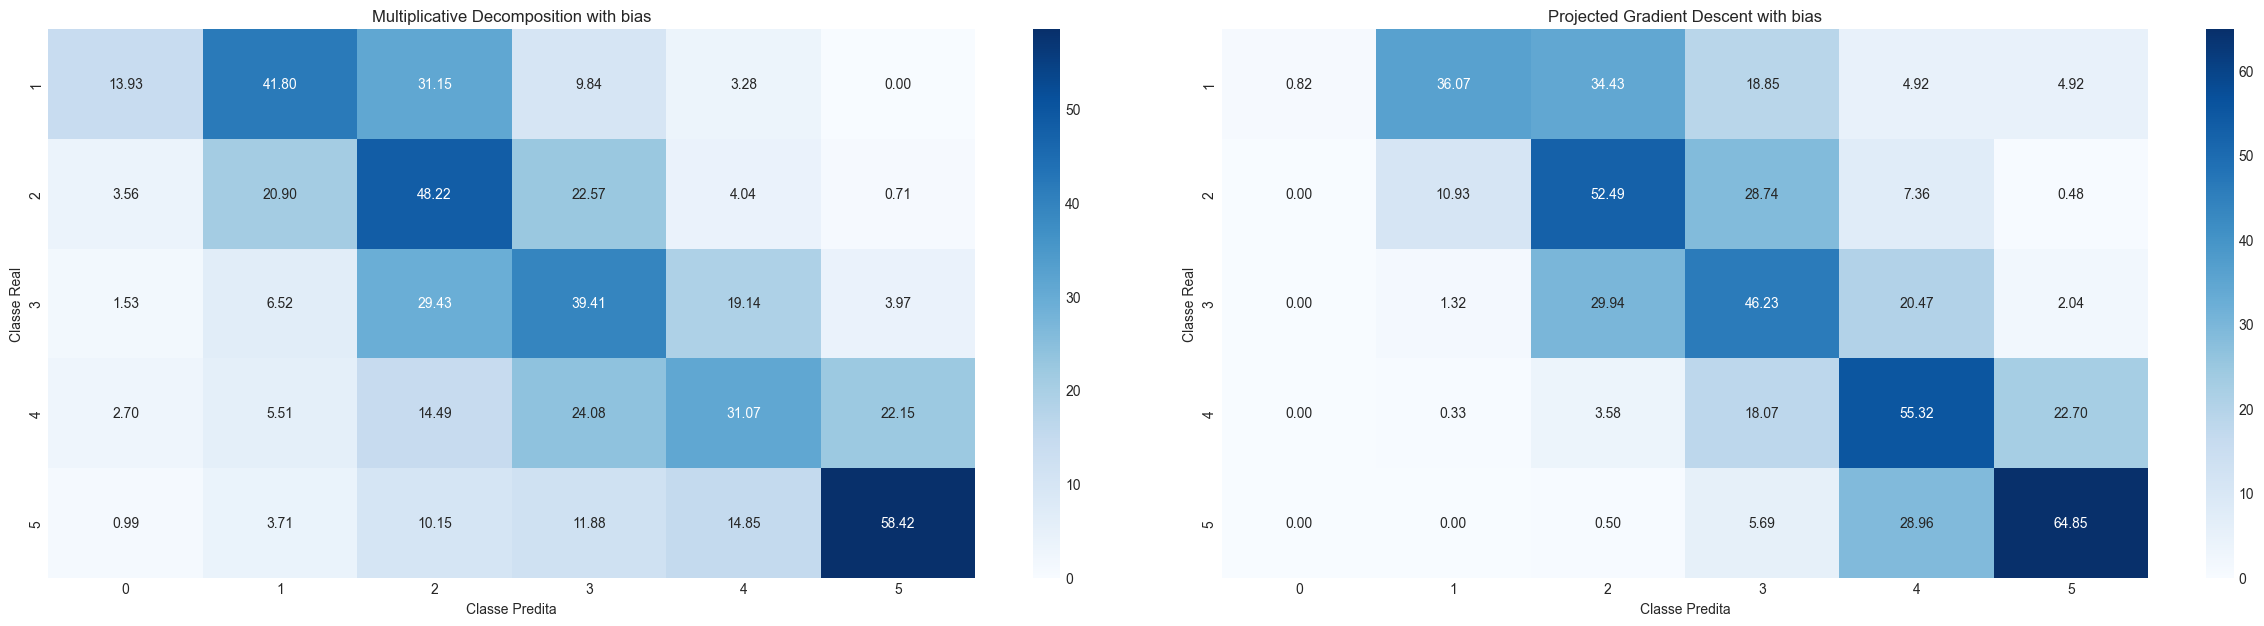

In [144]:
plot_functions=[
    #partial(plot_confusion_matrix_heatmap_normalized, cm=cm_original, title="Multiplicative Decomposition"),
    partial(plot_confusion_matrix_heatmap_normalized, cm=cm_original_with_bias, title="Multiplicative Decomposition with bias"),
    #partial(plot_confusion_matrix_heatmap_normalized, cm=cm_pgd_no_bias, title="Projected Gradient Descent"),
    partial(plot_confusion_matrix_heatmap_normalized, cm=cm_pgd_with_bias, title="Projected Gradient Descent with bias"),
]

# --- Run the code ---
grid_size = (2, 4) # Simplified grid for this example
coordinates = [(0, (0, 2)), (0, (2, 4)), (1, (0, 2)), (1, (2, 4))]

my_figure = create_complex_grid(grid_size, coordinates, plot_functions)